<center>
    <span style="color: #2E86C1; font-size: 3em;">
        &#128202; Preprocessing Data
    </span>
</center>

# Nội dung Notebook

Notebook này tập trung cung vào việc xử lý dữ liệu đã được EDA để trích xuất ra bộ dữ liệu ổn định về phương diện chất lượng và số lượng cho việc huấn luyện mô hình tiếp theo

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from kneed import KneeLocator

# Tổng quan notebook

| Tên đặc trưng         | Nội dung tiền xử lý                                                  |
|-----------------------|----------------------------------------------------------------------|
| **id**                | Loại bỏ                                                               |
| **sale_date**         | Phân tách date &rarr; year, month, day                            |
| **sale_price**        | Giữ không đổi                                                              |
| **sale_nbr**          | Điền giá trị khuyết bằng median của train                            |
| **sale_warning**      | Loại bỏ                                               |
| **join_status**       | Gom nhóm đặc trưng- Chuyển thành category                                          |
| **join_year**         | Loại bỏ                       |
| **latitude**          | Dùng để tạo đặc trưng mới |
| **longitude**         | Dùng để tạo đặc trưng mới |
| **area**              |                                                            |
| **city**              | Loại bỏ |
| **zoning**            | Dùng để tạo đặc trưng mới |
| **subdivision**       | Loại bỏ |
| **present_use**       |                                           |
| **land_val**          | Dùng để tạo đặc trưng mới |
| **imp_val**           | Giữ không đổi |
| **year_built**        |                                                     |
| **year_reno**         |                                                         |
| **sqft_lot**          | Giữ không đổi |
| **sqft**              |                                  |
| **sqft_1**            |                                      |
| **sqft_fbsmt**        |                                                    |
| **grade**             |                                            |
| **fbsmt_grade**       |                                            |
| **condition**         |                     |
| **stories**           |                                                              |
| **beds**              |                                                             |
| **bath_full**         |                                                      |
| **bath_3qtr**         |                                                      |
| **bath_half**         |                                                      |
| **garb_sqft**         |                                                  |
| **gara_sqft**         |                                                        |
| **wfnt**              |                                                    |
| **golf**              |                                                   |
| **greenbelt**         |                    |
| **noise_traffic**     |            |
| **view_rainier**      |                                            |
| **view_olympics**     |                                        |
| **view_cascades**     |                                       |
| **view_territorial**  |                |
| **view_skyline**      |                          |
| **view_sound**        |                                 |
| **view_lakewash**     |                                         |
| **view_lakesamm**     |                                          |
| **view_otherwater**   |                                   |
| **view_other**        |               |
| **submarket**         |                                 |





| New features         | Mô tả                                                  |
|-----------------------|----------------------------------------------------------------------|
| **new_features_1**      | Đặc trưng mới được tạo từ tổng diện tích sàn và diện tích tầng hầm                |
| **new_features_2**      | Đặc trưng phân loại theo nhóm giá trị sale_price (low, medium, high)              |
| **new_features_3**      | Đặc trưng tương tác giữa số phòng ngủ và phòng tắm                                |
| **new_features_4**      | Đặc trưng xác định bất động sản có tầm nhìn đặc biệt (tổng hợp các view_*)        |
| **new_features_5**      | Đặc trưng tỷ lệ diện tích xây dựng trên diện tích đất (sqft / sqft_lot)           |
| **val_per_sqft**        | Đặc trưng giá trị đất trên $m^2$                                                  |
| **hotzone_cluster**     | Đặc trưng các nhà có vị trí địa lý nằm ở các vùng có giá trị đất trên $m^2$ khác nhau tương đối rõ ràng |
| **zoning_cluster**      | Đặc trưng các nhà có zoning phân biệt rõ ràng dựa trên giá đất trên $m^2$ |

## Đọc dữ liệu

In [3]:
data_folder='../Dataset/'

In [4]:
data = pd.read_csv(data_folder + 'dataset.csv')
test_data = pd.read_csv(data_folder + 'test.csv')

In [5]:
train_data = data.drop('id', axis = 1)

# I. Nhóm đặc trưng về giao dịch mua bán

## Tiền xử lý sale_date

Đưa dữ liệu ngày tháng thành giá trị số liên tục nhằm biến đổi thành đặc trưng có thể sử dụng cho huấn luyện mô hình, dữ liệu được chuyển đổi thành khoảng cách so với 1 mốc thời gian.

In [6]:
invalid__train_dates = train_data['sale_date'][~train_data['sale_date'].astype(str).str.match(r'^\d{4}-\d{2}-\d{2}$')]
print("Invalid train__sale_date formats:", invalid__train_dates.unique())


Invalid train__sale_date formats: []


In [7]:
invalid_dates_test = test_data['sale_date'][~test_data['sale_date'].astype(str).str.match(r'^\d{4}-\d{2}-\d{2}$')]
print("Invalid test__sale_date formats:", invalid_dates_test.unique())

Invalid test__sale_date formats: []


In [8]:
train_data['sale_date'] = pd.to_datetime(train_data['sale_date'], errors='coerce')
train_data['sale_year'] = train_data['sale_date'].dt.year
train_data['sale_month'] = train_data['sale_date'].dt.month
train_data['sale_day'] = train_data['sale_date'].dt.day
train_data = train_data.drop('sale_date', axis=1)

In [9]:
test_data['sale_date'] = pd.to_datetime(test_data['sale_date'], errors='coerce')
test_data['sale_year'] = test_data['sale_date'].dt.year
test_data['sale_month'] = test_data['sale_date'].dt.month
test_data['sale_day'] = test_data['sale_date'].dt.day
test_data.drop('sale_date', axis=1, inplace=True)


## Tiền xử lý sale_price: Giữ không xoá bỏ outlier

## Tiền xử lý sale_nbr

In [10]:
print(train_data['sale_nbr'].isnull().sum())

42182


In [11]:
print(test_data['sale_nbr'].isnull().sum())

42412


In [12]:
sale_nbr_meadian=train_data['sale_nbr'].median()
train_data.loc[:, 'sale_nbr'] = train_data['sale_nbr'].fillna(sale_nbr_meadian)
test_data.loc[:, 'sale_nbr'] = test_data['sale_nbr'].fillna(sale_nbr_meadian)

## Tiền xử lý sale_warning

90% đặc trưng này chung một giá trị, 10% còn lại được phân bố cho hơn 140 giá trị categorical khác nhau đồng thời ít tương quan với thuộc tính nhãn nên xoá đi

In [13]:
train_data=train_data.drop(columns=['sale_warning'])
test_data=test_data.drop(columns=['sale_warning'])

## Tiền xử lý join_status

In [14]:
train_data['join_status'].value_counts()

join_status
nochg               126281
new                  53085
reno - before         5864
rebuilt - before      3706
rebuilt - after       3095
demo                  2869
reno - after          2632
miss99                2468
Name: count, dtype: int64

In [15]:
test_data['join_status'].value_counts()

join_status
nochg               126519
new                  52648
reno - before         6001
rebuilt - before      3568
rebuilt - after       3146
demo                  2866
reno - after          2654
miss99                2598
Name: count, dtype: int64

In [16]:
train_data['join_status'] = train_data['join_status'].replace(
    ['miss99', 'demo', 'rebuilt - after', 'reno - after'], 'nochg'
).astype('category')
test_data['join_status'] = test_data['join_status'].replace(
    ['miss99', 'demo', 'rebuilt - after', 'reno - after'], 'nochg'
).astype('category')

## Tiền xử lý join_year

Đặc trưng này thể hiện tương quan kém với nhãn mục tiêu, đồng thời nội dung có thể suy ra từ đặc trưng join_status

In [17]:
train_data=train_data.drop(columns=['join_year'])
test_data=test_data.drop(columns=['join_year'])

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 46 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   sale_price        200000 non-null  int64   
 1   sale_nbr          200000 non-null  float64 
 2   join_status       200000 non-null  category
 3   latitude          200000 non-null  float64 
 4   longitude         200000 non-null  float64 
 5   area              200000 non-null  int64   
 6   city              200000 non-null  object  
 7   zoning            200000 non-null  object  
 8   subdivision       182450 non-null  object  
 9   present_use       200000 non-null  int64   
 10  land_val          200000 non-null  int64   
 11  imp_val           200000 non-null  int64   
 12  year_built        200000 non-null  int64   
 13  year_reno         200000 non-null  int64   
 14  sqft_lot          200000 non-null  int64   
 15  sqft              200000 non-null  int64   
 16  sq

# II. Nhóm đặc trưng địa lý

In [ ]:
geography_feature = ['latitude', 'longitude', 'city', 'zoning', 'subdivision', 'land_val', 'imp_val', 'sqft_lot']

geography_data = train_data[geography_feature].copy()

geography_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   latitude     200000 non-null  float64
 1   longitude    200000 non-null  float64
 2   city         200000 non-null  object 
 3   zoning       200000 non-null  object 
 4   subdivision  182450 non-null  object 
 5   land_val     200000 non-null  int64  
 6   imp_val      200000 non-null  int64  
 7   sqft_lot     200000 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 12.2+ MB


In [ ]:
geography_data.describe()

,latitude,longitude,land_val,imp_val,sqft_lot
count,200000.000000,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05
mean,47.549248,-122.210416,4.601691e+05,4.917715e+05,1.378310e+04
std,0.142710,0.140339,3.510444e+05,3.680505e+05,3.793152e+04
min,47.155200,-122.527700,0.000000e+00,0.000000e+00,3.750000e+02
25%,47.446500,-122.323800,2.310000e+05,2.800000e+05,5.000000e+03
50%,47.562800,-122.222700,3.770000e+05,4.090000e+05,7.438000e+03
75%,47.673500,-122.121700,5.940000e+05,5.990000e+05,1.022000e+04
max,47.777800,-121.161300,1.386400e+07,1.006700e+07,2.310573e+06


In [ ]:
geography_data["val_per_sqft"] = geography_data["land_val"] / geography_data["sqft_lot"]

## 1. Feature Engineer - Tạo hotzone các vùng có giá trị đất trên $m^2$ cao.

- Đầu tiên ta sử dụng Elbow Method để tìm giá trị k phù hợp nhất để sử dụng cho phân cụm k-mean kế tiếp

- Đồng thời ta cũng sử dụng KneeLocator để xác định chính xác elbow.

Optimal cluster based on Elbow Method (KneeLocator): k = 9


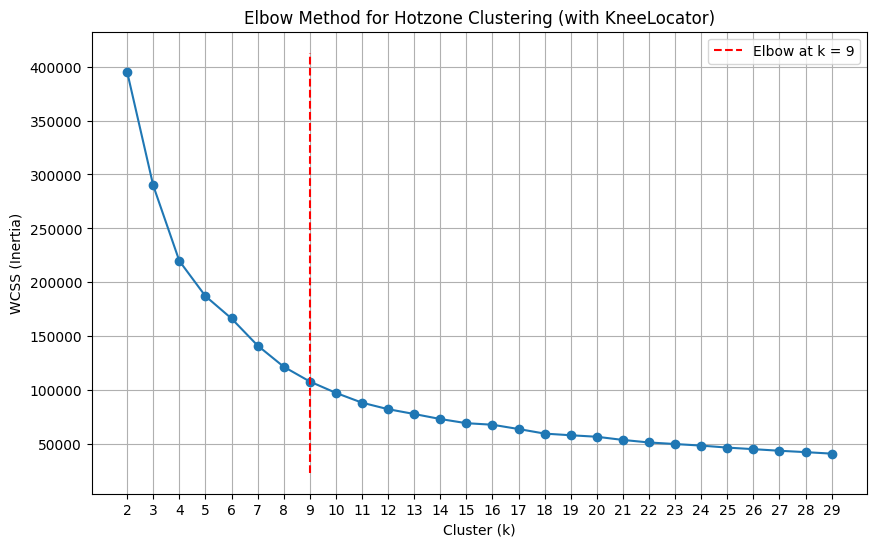

In [ ]:
# Bước 1: Lấy dữ liệu và chuẩn hóa
valid_data = geography_data[["latitude", "longitude", "val_per_sqft"]].copy()
scaled_data = StandardScaler().fit_transform(valid_data)

# Bước 2: Elbow Method + tính WCSS
wcss = []
K = range(2, 30)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Bước 3: Dùng KneeLocator để tìm elbow
hotzone_knee = KneeLocator(K, wcss, curve='convex', direction='decreasing')
print(f"Optimal cluster based on Elbow Method (KneeLocator): k = {hotzone_knee.knee}")

# Bước 4: Vẽ biểu đồ có đánh dấu điểm elbow
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o')
plt.vlines(hotzone_knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", colors="red", label=f"Elbow at k = {hotzone_knee.knee}")
plt.title('Elbow Method for Hotzone Clustering (with KneeLocator)')
plt.xlabel('Cluster (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(K)
plt.grid(True)
plt.legend()
plt.show()

- Dựa vào kết quả của đoạn mã trên, ta quyết định sử dụng k=9 cho việc phân cụm các hotzone.

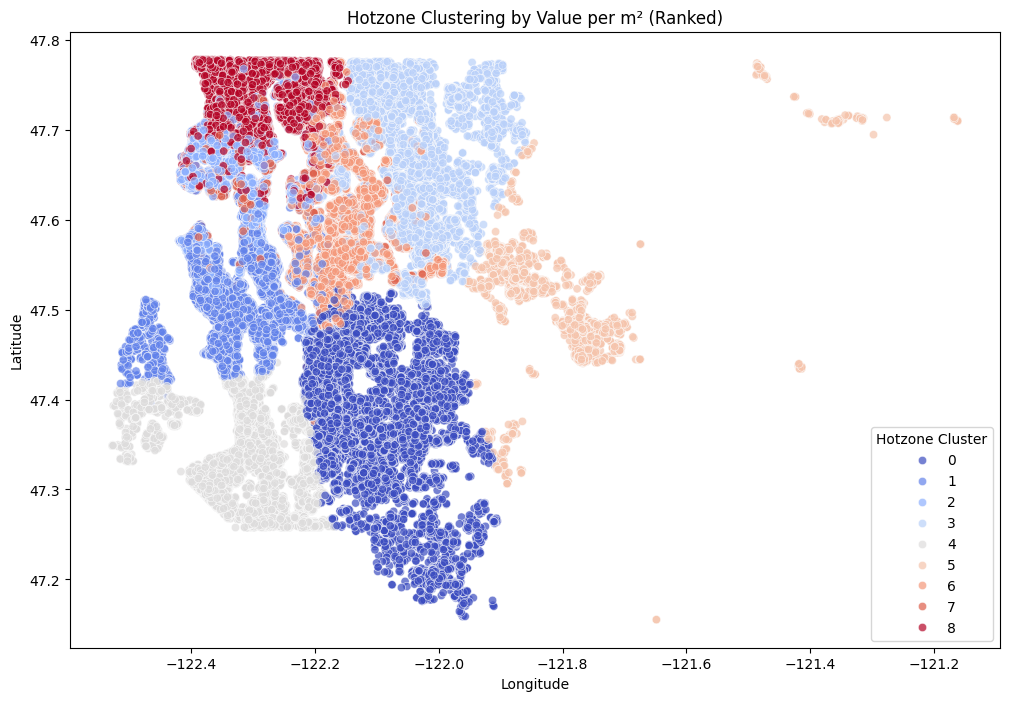

In [ ]:
# Bước 1: Chuẩn hóa dữ liệu đầu vào
hotzone_features = geography_data[["latitude", "longitude", "val_per_sqft"]].dropna()
scaler_hotzone = StandardScaler()
scaled_hotzone = scaler_hotzone.fit_transform(hotzone_features)

# Bước 2: Huấn luyện KMeans
kmeans_hotzone = KMeans(n_clusters=hotzone_knee.knee, random_state=42)
geography_data["hotzone_cluster"] = kmeans_hotzone.fit_predict(scaled_hotzone)

# --- Bước 6: Visualization ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=geography_data,
    x="longitude",
    y="latitude",
    hue="hotzone_cluster",
    palette="coolwarm",
    legend="full",
    alpha=0.7
)
plt.title("Hotzone Clustering by Value per m² (Ranked)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Hotzone Cluster")
plt.show()

## 2. Feature Engineer - Gom các zoning lại thành các cụm có ý nghĩa.

In [ ]:
geography_data['zoning'].unique().__len__()

500

- Như ta đã thấy, có tới 500 giá trị khác nhau trong `zoning`, mà chúng còn là những chuỗi ký tự, thứ mà các model khó mà học hiệu quả được.
- Do đó ta sẽ dựa vào giá trị đất trên $m^2$ trung của các zoning để chia chúng thành những cluster có ý nghĩa hơn.
- Ta cũng sẽ làm tương tự như trên, sử dụng KneeLocator và Elbow Method để xác định số k phù hợp để phân cụm
- Sử dụng k-mean cluster để phân cụm

Optimal cluster based on Elbow Method (KneeLocator): k = 7


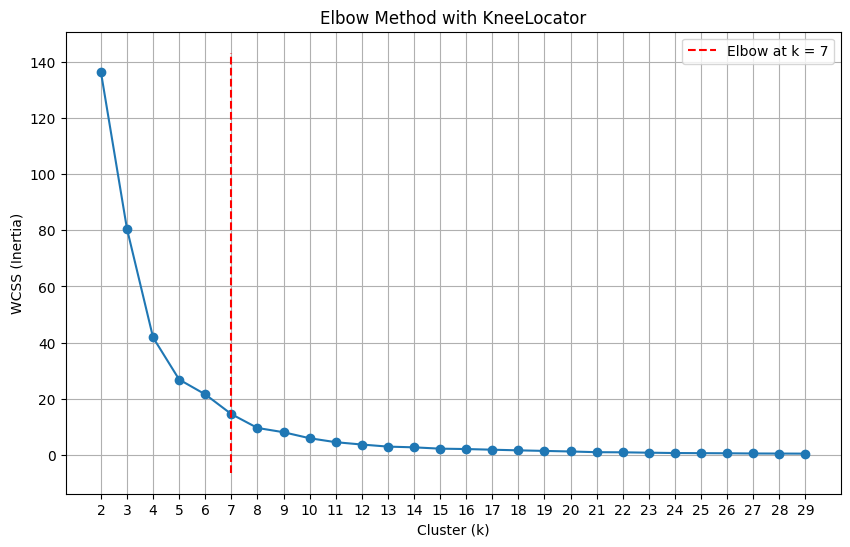

In [ ]:
# Tính median val_per_sqft theo zoning
zoning_val_df = geography_data.groupby("zoning")["val_per_sqft"].median().reset_index()
zoning_val_df.rename(columns={"val_per_sqft": "median_val_per_sqft"}, inplace=True)

# Chuẩn hóa
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(zoning_val_df[["median_val_per_sqft"]])

# Elbow Method: tính WCSS
wcss = []
K_range = range(2, 30)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_vals)
    wcss.append(kmeans.inertia_)

# Dùng KneeLocator để tìm điểm gãy
zoning_knee = KneeLocator(K_range, wcss, curve="convex", direction="decreasing")
print(f"Optimal cluster based on Elbow Method (KneeLocator): k = {zoning_knee.knee}")

# Vẽ biểu đồ Elbow có highlight điểm elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o')
plt.vlines(zoning_knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", colors="red", label=f"Elbow at k = {zoning_knee.knee}")
plt.title('Elbow Method with KneeLocator')
plt.xlabel('Cluster (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(K)
plt.grid(True)
plt.legend()
plt.show()

- Dựa vào kết quả của đoạn mã trên, chúng ta sẽ sử dụng k=6 cho việc phân cụm kế tiếp.

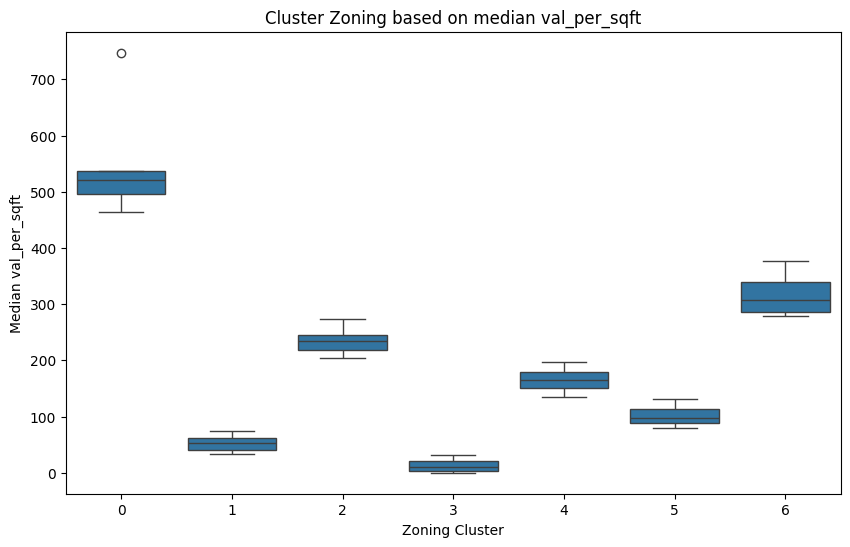

In [ ]:
# Tính median val_per_sqft theo zoning
zoning_val_df = geography_data.groupby("zoning")["val_per_sqft"].median().reset_index()
zoning_val_df.rename(columns={"val_per_sqft": "median_val_per_sqft"}, inplace=True)

# Chuẩn hóa và gom cụm zoning
scaler_zoning = StandardScaler()
scaled_zoning = scaler_zoning.fit_transform(zoning_val_df[["median_val_per_sqft"]])

kmeans_zoning = KMeans(n_clusters=zoning_knee.knee, random_state=42)
zoning_val_df["zoning_cluster"] = kmeans_zoning.fit_predict(scaled_zoning)

# Tạo mapping zoning → cluster
zoning_cluster_mapping = dict(zip(zoning_val_df["zoning"], zoning_val_df["zoning_cluster"]))

# Gán cluster vào train
geography_data["zoning_cluster"] = geography_data["zoning"].map(zoning_cluster_mapping)

plt.figure(figsize=(10, 6))
sns.boxplot(data=zoning_val_df, x="zoning_cluster", y="median_val_per_sqft")
plt.title("Cluster Zoning based on median val_per_sqft")
plt.xlabel("Zoning Cluster")
plt.ylabel("Median val_per_sqft")
plt.show()

In [ ]:
geography_data

,latitude,longitude,city,zoning,subdivision,land_val,imp_val,sqft_lot,val_per_sqft,hotzone_cluster,zoning_cluster
0,47.2917,-122.3658,FEDERAL WAY,RS7.2,ALDERWOOD SOUTH DIV NO. 02,167000,372000,10919,15.294441,4,3
1,47.6531,-122.1996,KIRKLAND,RS 8.5,WILDWOOD LANE NO. 03,1184000,598000,8900,133.033708,6,5
2,47.4733,-122.1901,RENTON,R-8,FALCON RIDGE (CEDAR RIDGE),230000,356000,4953,46.436503,0,1
3,47.4739,-122.3295,BURIEN,RS-7200,OLYMPIC VUE ESTATES,190000,518000,6799,27.945286,1,3
4,47.7516,-122.1222,KING COUNTY,RA2.5,HOLLYWOOD HILL HIGHLANDS,616000,1917000,31687,19.440149,3,3
...,...,...,...,...,...,...,...,...,...,...,...
199995,47.5503,-122.0285,ISSAQUAH,SF-E,OVERDALE PARK NO. 03,521000,620000,29250,17.811966,3,3
199996,47.6789,-122.1164,REDMOND,NMF,C P,667000,1107000,7677,86.882897,6,5
199997,47.6939,-122.3542,SEATTLE,LR3 (M),OSNERS SUBURBAN HOMES ADD,225000,492000,808,278.465347,7,2
199998,47.6433,-122.0613,SAMMAMISH,R4,TIMBERLINE NO. 01,554000,617000,11712,47.301913,3,1


- Áp dụng vào train_data

In [ ]:
train_data = train_data.reset_index(drop=True)
geography_data = geography_data.reset_index(drop=True)

train_data["val_per_sqft"] = geography_data["val_per_sqft"]
train_data["hotzone_cluster"] = geography_data["hotzone_cluster"]
train_data["zoning_cluster"] = geography_data["zoning_cluster"]

- Sau khi feature engineer, 3 đặc trưng mới này đã thể hiện đầy đủ ý nghĩa địa lý của dữ liệu. Do đó, ta sẽ xóa các đặc trưng địa lý.

In [ ]:
drop_cols = ['latitude', 'longitude', 'zoning', 'land_val', 'city', 'subdivision']
train_data.drop(columns=drop_cols, inplace=True, errors='ignore')

- Áp dụng feature engineer cho test

In [ ]:
# Tính val_per_sqft cẩn thận để tránh chia cho 0
test_data["val_per_sqft"] = test_data.apply(
    lambda row: row["land_val"] / row["sqft_lot"] if row["sqft_lot"] > 0 else 0,
    axis=1
)

In [ ]:
# Bước 1: Chuẩn hóa với scaler đã huấn luyện
test_hotzone_input = test_data[["latitude", "longitude", "val_per_sqft"]]
scaled_test = scaler_hotzone.transform(test_hotzone_input)

# Bước 2: Dự đoán cụm hotzone từ mô hình đã học
test_data["hotzone_cluster"] = kmeans_hotzone.predict(scaled_test)

In [ ]:
# Gán zoning_cluster từ mapping đã học
test_data["zoning_cluster"] = test_data["zoning"].map(zoning_cluster_mapping)

# Nếu có zoning chưa từng gặp
test_data["zoning_cluster"] = test_data["zoning_cluster"].fillna(-1)  

In [ ]:
test_data.drop(columns=drop_cols, inplace=True, errors='ignore')